In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
from modules.infererence.preprocessing import *
from modules.infererence.object_detection import *
from modules.infererence.nms import filter
import matplotlib.pyplot as plt
import cv2
import zipfile
import numpy as np

In [3]:
# Load all imanges and ground truth from logistics
folder_path = os.path.join('..', 'logistics')
images, image_names = load_image_and_name(folder_path)
ground_truths = load_ground_truth(folder_path, image_names)

In [4]:
# Example print
image_name_test = '4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9'
print(ground_truths[image_name_test])

['6 0.5 0.525 1 0.54375']


In [5]:
# Test case
if image_name_test in image_names:
    print(True)
else:
    print(False)

True


In [6]:
# Apply the Model for predictions
def get_prediction_filtered(images, image_names, yolo_model, objectiveness_threshold=0.5, nms_iou_threshold=0.4):
    predictions = {}

    for image, image_name in zip(images, image_names):
        
        # Get predictions, apply nms filter
        image_prediction = yolo_model.predict(image)
        bboxes, class_ids, scores = yolo_model.post_process(image_prediction, objectiveness_threshold=objectiveness_threshold)
        filtered_bboxes, filtered_class_ids, filtered_scores = filter(bboxes, class_ids, scores, nms_iou_threshold=nms_iou_threshold)

        # Save predictions for this image
        predictions[image_name] = (filtered_class_ids, filtered_bboxes, filtered_scores)
    
    return predictions


In [7]:
# Evaluate the performance of the model by calculating IoU for each prediction
def evaluate_model(database_predictions, ground_truths, iou_threshold=0.5):
    
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    total_gt_bbox = 0
    precision_recall_points = {}
    
    
    for image_name, predictions in database_predictions.items():
        # Get ground truth information and convert to float
        annotations = ground_truths.get(image_name, [])
        annotations = [list(map(float, annotation.split())) for annotation in annotations]

        num_true_bbox = len(annotations) # Number of true bbox in the image
        total_gt_bbox += num_true_bbox
        num_pred_bbox = len(predictions[0]) # Number of preicated bbox in the image
        num_association = 0

        # Get each prediction paird with class ID, bbox, and objectiveness score
        filtered_class_ids, filtered_bboxes, filtered_scores = predictions
        paired_predictions = [
        [class_id, *bbox, score] for class_id, bbox, score in zip(filtered_class_ids, filtered_bboxes, filtered_scores)
    ]

        # Box association
        assigned_prediction = assign_true_object(paired_predictions, annotations, iou_threshold=iou_threshold)

        tp = 0
        fp = 0
        num_pred_image = 0

        for object in assigned_prediction:
            pred_id, pred_score = object[0], object[5]
            num_pred_image += 1
            # If associated, len(assigned_predictions)=8 
            # [pred_class, pred_x, pred_y, pred_w, pred_h, objectiveness_score, true_class, true_bbox]
            # This is a TP
            if len(object) == 8:
                if object[0] == object[-2]: # If predicted class match true class
                    num_association += 1
                    total_true_positives += 1
                    tp += 1

            # This is a FP
            if len(object) < 8: # For predicted bbox which is not associated
                total_false_positives += 1

            precision = total_true_positives / (total_true_positives + total_false_positives + 1e-5)
            recall = total_true_positives / (total_gt_bbox + 1e-5)

            # In each image, add [confidence socre, (precision, recall)] for each object
            if pred_id not in precision_recall_points:
                precision_recall_points[pred_id] = []
            precision_recall_points[pred_id].append([pred_score, (precision, recall)])

        # False negative: ground truth not detected
        total_false_negatives += num_true_bbox - num_association

    print(f'Number of images predicted: {len(database_predictions)}')
    print(f'Total ground truth boxes: {total_gt_bbox}')
    print(f'TP: {total_true_positives}')
    print(f'FP: {total_false_positives}')
    print(f'FN: {total_false_negatives}')

   
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


    return precision, recall, precision_recall_points


In [8]:
# To plot the precision recall curve for certain class
def plot_precision_recall_curve(precision_recall_points, class_id):
    points = precision_recall_points.get(class_id, [])
    # Sort points by recall in ascending order for a smoother curve
    points = sorted(points, key=lambda x: x[1][1], reverse=True)  # x[1][1] is the recall value
    
    precisions = [point[1][0] for point in points]
    recalls = [point[1][1] for point in points]

    # Check if both lists are of the same length
    if len(precisions) != len(recalls):
        raise ValueError("The precision and recall lists must have the same length.")

    plt.figure(figsize=(6, 4))
    plt.plot(recalls, precisions, color='b')

    # Set plot labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve, Class {class_id}')

    # Set grid
    plt.grid(True)

    # Display the plot
    plt.show()


In [9]:
# Calculate mean average precision
def calculate_map(precision_recall_points, num_classes):
    """
    Calculate the mean average precision (mAP) using 11-point interpolation for multi-class tasks.

    Args:
        precision_recall_points (dict): A dictionary where keys are class indices and values are lists: 
        [confidence socre, (precision, recall)].
        num_classes (int): Number of classes.

    Returns:
        float: The mAP value.
    """
    mean_average_precisions = []
    ap_per_class = {}

    for class_id in range(num_classes):
        points = precision_recall_points.get(class_id, [])
        if not points:
            mean_ap = 0
        else:
            # Sort by confidence score in descending order
            points = sorted(points, key=lambda x: x[0], reverse=True)

            interpolated_precisions = []
            for recall_threshold in [j * 0.1 for j in range(11)]:
                # Find all precisions meet the recall_threshold
                possible_precisions = [p for _, (r, p) in points if r >= recall_threshold]
                if possible_precisions:
                    interpolated_precisions.append(max(possible_precisions))
                else:
                    interpolated_precisions.append(0)

            # Average precision for this class
            mean_ap = sum(interpolated_precisions) / len(interpolated_precisions)

        # Store the AP for this class
        ap_per_class[class_id] = mean_ap
        mean_average_precisions.append(mean_ap)

    # Calculate overall map
    overall_map = sum(mean_average_precisions) / num_classes
    
    print(f"mAP: {overall_map:.4f}")
    
    return overall_map, ap_per_class


In [10]:
# Function to load class names
def load_class_names(names_file):
    with open(names_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    return class_names

In [11]:
# Function to plot per-class AP for two models using actual class names
def plot_map_per_class(ap_per_class_1, ap_per_class_2, class_names):
    num_classes = len(class_names)

    # Extract the AP values for both models
    ap_values_1 = [ap_per_class_1.get(i, 0) for i in range(num_classes)]
    ap_values_2 = [ap_per_class_2.get(i, 0) for i in range(num_classes)]

    bar_width = 0.35
    index = np.arange(num_classes)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot for Model 1
    bars1 = ax.bar(index, ap_values_1, bar_width, label='YOLO Model 1', color='b')
    # Plot for Model 2
    bars2 = ax.bar(index + bar_width, ap_values_2, bar_width, label='YOLO Model 2', color='r')

    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision (AP)')
    ax.set_title('Per-Class Average Precision (AP) for YOLO Models')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    # Annotate the bars with their AP values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text above the bar
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Performance of YOLO Model 1

In [12]:
# Load YOLO Model 1
yolo_version = 1

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', f'yolo_model_{yolo_version}', 'logistics.names')

yolo_model_1 = Model(model_config, model_weights, class_names)

In [13]:
# Make predictions using YOLO model 1
predictions_1 = get_prediction_filtered(images, image_names, yolo_model_1, objectiveness_threshold=0.5, nms_iou_threshold=0.4)

In [14]:
# Evaluate YOLO model 1 performance
print("Evaluating YOLO Model 1")
precision_1, recall_1, precision_recall_points_1 = evaluate_model(predictions_1, ground_truths, iou_threshold=0.6)
overall_map_1, ap_per_class_1 = calculate_map(precision_recall_points_1, num_classes=20)

Evaluating YOLO Model 1
Number of images predicted: 9513
Total ground truth boxes: 36667
TP: 13158
FP: 5564
FN: 23509
Precision: 0.7028
Recall: 0.3589
mAP: 0.3433


## Performance of YOLO Model 2

In [15]:
# Load YOLO Model 2
yolo_version = 2

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', f'yolo_model_{yolo_version}', 'logistics.names')

yolo_model_2 = Model(model_config, model_weights, class_names)

In [16]:
# Make predictions using YOLO model 2
predictions_2 = get_prediction_filtered(images, image_names, yolo_model_2, objectiveness_threshold=0.5, nms_iou_threshold=0.4)

In [17]:
# Evaluate YOLO model 1 performance
print("Evaluating YOLO Model 2")
precision_2, recall_2, precision_recall_points_2 = evaluate_model(predictions_2, ground_truths, iou_threshold=0.6)
overall_map_2, ap_per_class_2 = calculate_map(precision_recall_points_2, num_classes=20)

Evaluating YOLO Model 2
Number of images predicted: 9513
Total ground truth boxes: 36667
TP: 14970
FP: 5237
FN: 21697
Precision: 0.7408
Recall: 0.4083
mAP: 0.3770


In [21]:
# Load class namens for plotting
class_names_content = load_class_names(class_names)

In [22]:
print(class_names_content)

['barcode', 'car', 'cardboard box', 'fire', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'smoke', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


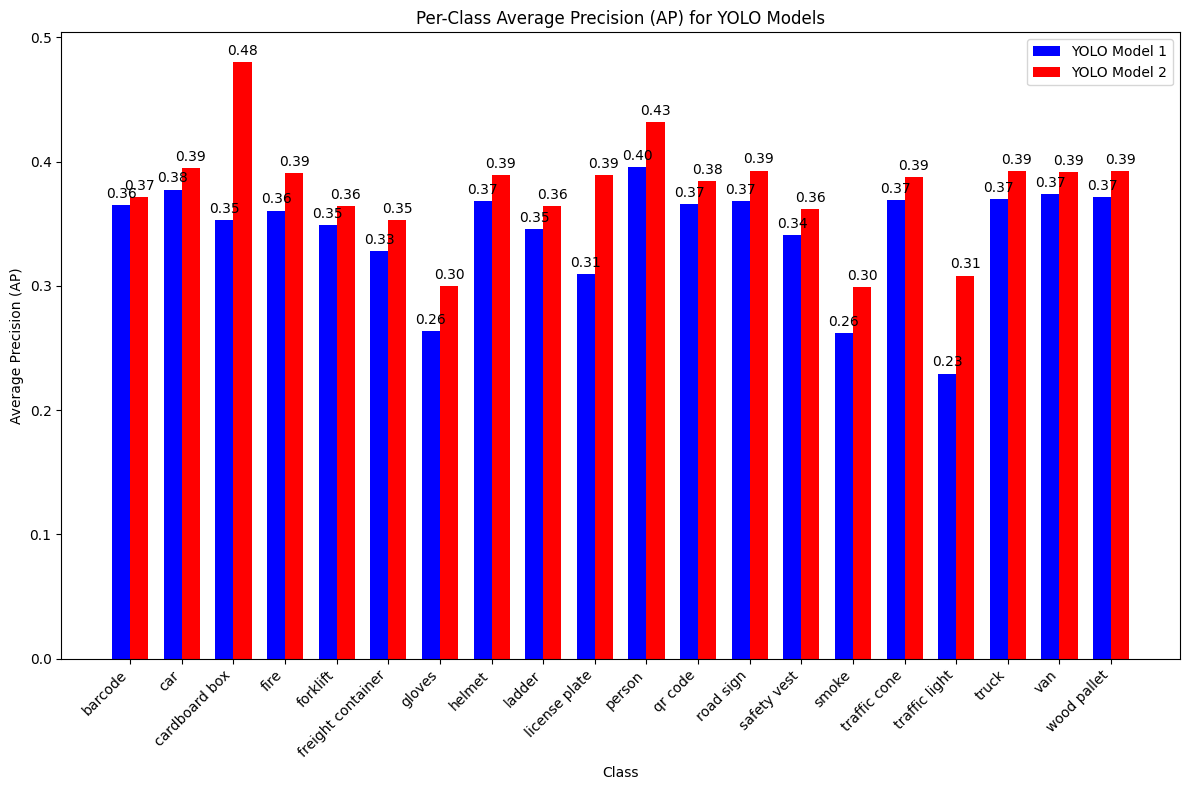

In [23]:
plot_map_per_class(ap_per_class_1, ap_per_class_2, class_names_content)

**Precision:** measures the proportion of correct positive detections out of all detections made by the model. Model 2 has a slightly higher precision (0.7639) compared to Model 1 (0.7265). This indicates that Model 2 is slightly better at making accurate detections.

**Recall:** measures how many of the true objects were detected by the model. Model 2 again has a higher recall (0.4836) compared to Model 1 (0.4086). This suggests that Model 2 is slightly better at identifying more objects in the image.

**Mean IoU:** measures how well the predicted bounding boxes overlap with the ground truth bounding boxes. It is almost the same for both models (Model 1: 0.7919, Model 2: 0.7910). They both localize the objects with a similar level of accuracy.

**Mean Average Precision (MAP):** captures both precision and recall across multiple thresholds. Model 1 has a higher mAP (0.4512) compared to Model 2 (0.3864). The MAP score suggests that Model 1 performs better overall in detecting objects across all confidence thresholds, despite having slightly lower precision and recall.

**Per-Class AP Comparison:** Model 1 dominates in certain critical classes like "gloves", "safety vest", and "person", where accurate detection might be more important in certain logistics applications (e.g., detecting safety equipment). Model 2 outperforms Model 1 in other classes like "cardboard box", "truck", and "van", which might be more important in tasks related to vehicle and package detection. 

In general, the choice of the model ultimately depends on the specific requirements of the application and the importance of certain object classes. if the objective is to achieve better overall performance and stronger detection in categories like safety equipment, YOLO Model 1 should be chosen.